##  Cookie Cats A/B Test
### Context
Mobile Games dataset from Kaggle was compiled by Cookie Cats' developers. This dataset was compiled to identify, which game configuration makes the game more popular. Game developers randomly (note: this is explicitly stated in the description of the dataset) assigned players to game version, where a gate (which I believe is a sort of paywall) is introduced at level 30 (version = gate_30) or at level 40 (version = gate_40). The number of game rounds played after 14 day mark (sum_gamerounds), player retention after 1 day (retention_1) and after 7 days (retention_7) were recorded.
### Goal
The goal of this analysis is to find, which game version (gate_30 or gate_40) makes the game more popular.
### Target metrics
Number of game rounds played after 14 days (sum_gamerounds), player retention after day 1 (retention_1) and after day 7 (retention_7) were chosen. These three metrics are all indicitive of a popular game, so all three will be analyzed.
### The Basics
We start by importing some modules we wil be using:

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare, ttest_ind, chi2_contingency

We import the dataset .csv file into a Pandas dataframe and take a look at of df:

In [60]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


We will be ignoring userid, which is anonymous identifier as there is no use to it. The version column stores our independent variables and last three columns are the dependent variables of interest. Let's see double check if the values in the columns make sense:

In [61]:
df.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

We can see that, indeed, the values make sense. We have only two unique values for the version column (gate_30 and gate_40), for retention_1 and retention_7 columns also just two values (True or False). To double check, we should also test if there are any missing values:

In [62]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

There are no missing values. Lastly, let's check if the values in the continuous numerical column 'sum_gamerounds' make sense as well:

In [63]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

There are no negative values, which makes sense. We can see that there is a player with almost 50 thousand rounds played, which is a couple of hundreds of standard deviations away from the mean! Let's have a look at some boxplots, to see if we should remove this datapoint:

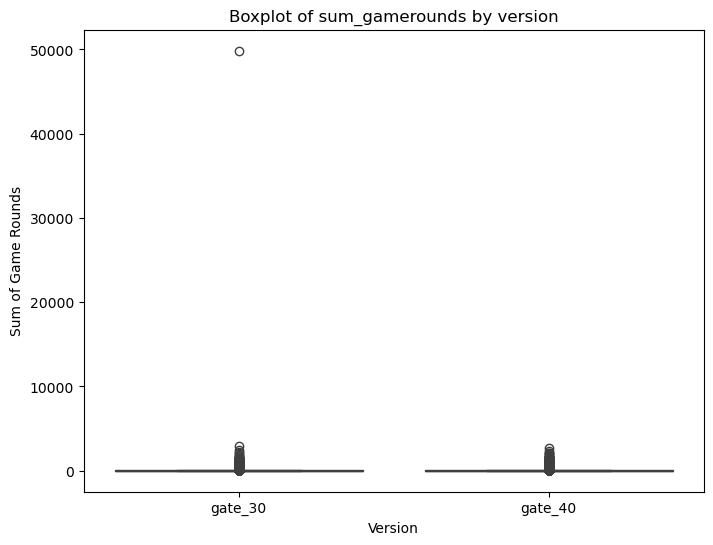

In [64]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title('Boxplot of sum_gamerounds by version')
plt.xlabel('Version')
plt.ylabel('Sum of Game Rounds')
plt.show()


It appears that this, indeed, is one of a kind datapoint, so we will remove it. Additionally, we will remove rows, where sum_gamerounds=0 as it represents players, who downloaded the game, but did not play, so they are not useful for our analysis. Let's take a look at some boxplots again after outlier removal:

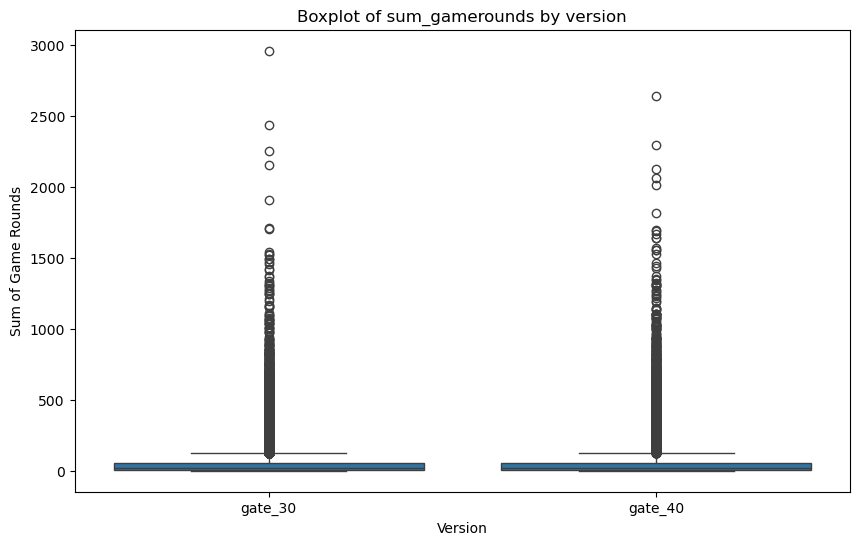

In [65]:
df = df[df['sum_gamerounds'] <= 10000]
df = df[df['sum_gamerounds'] != 0]

# Plotting boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title('Boxplot of sum_gamerounds by version')
plt.xlabel('Version')
plt.ylabel('Sum of Game Rounds')
plt.show()

This looks much more reasonable. Lets proceed with our data analysis.
### Data analysis
First let's have a look at game rounds played after 14 days for both version of the game. Let's compute means and 95% confidence intervals analytically and via bootstrap method. Also, let's look at the sample variant ratios for each group:

In [66]:
gate_30 = df[df['version'] == 'gate_30']['sum_gamerounds']
gate_40 = df[df['version'] == 'gate_40']['sum_gamerounds']

gates = [gate_30, gate_40]
versions = ['gate_30', 'gate_40']

# Function to perform bootstrapping
def bootstrap(data, n_bootstrap=1000):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return means

results = {
    'Version': [],
    'Rounds played (mean, analytical)': [],
    r'Analytical 95% CI': [],
    'Rounds played (mean, bootstrap)': [],
    r'Bootstrap 95% CI': [],
    'n': [],
    'Expected counts': [],
    'Variant proportion': []
}

total_count = len(gate_30) + len(gate_40)

# Expected counts (assuming equal proportion)
expected_counts = total_count / 2

for i, gate in enumerate(gates):
    mean_rounds = gate.mean()
    n = len(gate)
    proportion = n / total_count
    se = stats.sem(gate)
    ci = stats.norm.interval(0.95, loc=mean_rounds, scale=se)
    ci = (round(ci[0], 2), round(ci[1], 2))
    bootstrapping = bootstrap(gate, n_bootstrap=10000)
    bootstrap_mean = np.mean(bootstrapping)
    bootstrap_ci = (np.percentile(bootstrapping, 2.5), np.percentile(bootstrapping, 97.5))
    bootstrap_ci = (round(bootstrap_ci[0], 2), round(bootstrap_ci[1], 2))

    results['Version'].append(versions[i])
    results['Rounds played (mean, analytical)'].append(round(mean_rounds, 2))
    results[r'Analytical 95% CI'].append(ci)
    results['Rounds played (mean, bootstrap)'].append(round(bootstrap_mean,2))
    results[r'Bootstrap 95% CI'].append(bootstrap_ci)
    results['n'].append(n)
    results['Expected counts'].append(expected_counts)
    results['Variant proportion'].append(round(proportion, 4))

results_df = pd.DataFrame(results)
results_df

,Version,"Rounds played (mean, analytical)",Analytical 95% CI,"Rounds played (mean, bootstrap)",Bootstrap 95% CI,n,Expected counts,Variant proportion
0,gate_30,53.67,"(52.68, 54.65)",53.67,"(52.7, 54.65)",42762,43097.0,0.4961
1,gate_40,53.73,"(52.74, 54.72)",53.73,"(52.77, 54.73)",43432,43097.0,0.5039


We can see that that for both versions of the game rounds played after 14 days, on average, is around 53.7, when computed with either method. Sampling number for bootstrapping was set at 10,000. The confidence intervals are also extremely similar. We can see that there is a mismatch in sample ratio and we will test whether the difference is statistically significant shortly. But before that let's have a look at histograms of means sampled via the bootstrap method:

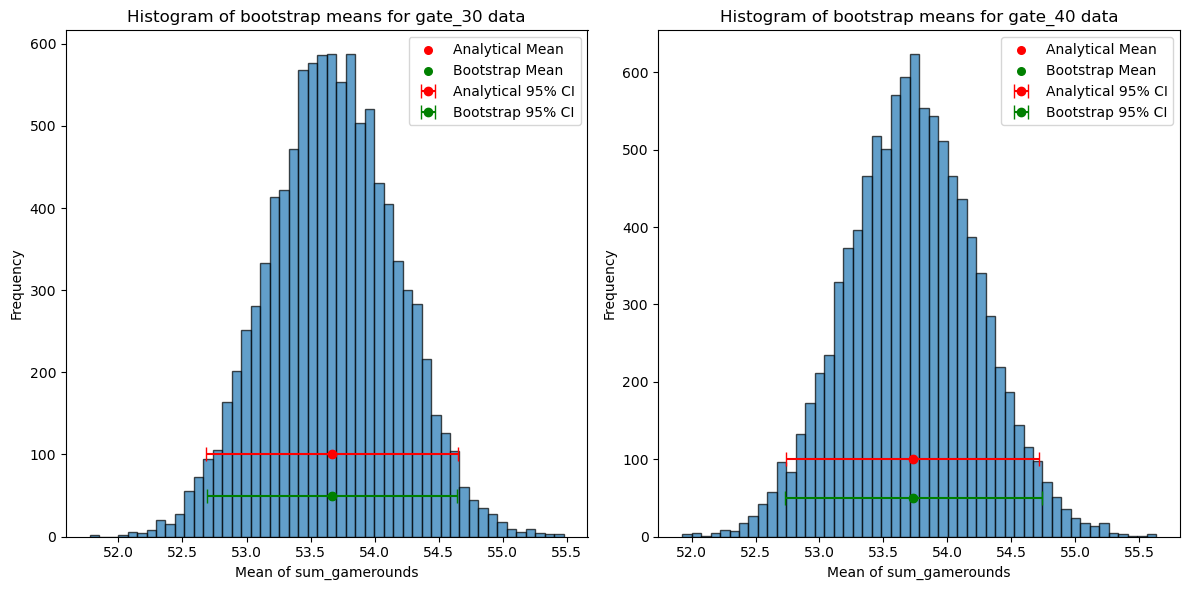

In [67]:
# Filter the data for 'gate_30' and 'gate_40' versions
gate_30_data = df[df['version'] == 'gate_30']['sum_gamerounds']
gate_40_data = df[df['version'] == 'gate_40']['sum_gamerounds']

# Function to perform bootstrapping
def bootstrap(data, n_bootstrap=1000):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return means

# Perform bootstrapping and get the means
bootstrap_means_30 = bootstrap(gate_30_data, n_bootstrap=10000)
bootstrap_means_40 = bootstrap(gate_40_data, n_bootstrap=10000)

# Calculate the means of bootstrapping means
mean_of_bootstrap_means_30 = np.mean(bootstrap_means_30)
mean_of_bootstrap_means_40 = np.mean(bootstrap_means_40)

# Calculate the analytically derived means
analytical_mean_30 = np.mean(gate_30_data)
analytical_mean_40 = np.mean(gate_40_data)

# Calculate the analytical 95% CI
sem_30 = np.std(gate_30_data, ddof=1) / np.sqrt(len(gate_30_data))
analytical_ci_30 = (analytical_mean_30 - 1.96 * sem_30, analytical_mean_30 + 1.96 * sem_30)

sem_40 = np.std(gate_40_data, ddof=1) / np.sqrt(len(gate_40_data))
analytical_ci_40 = (analytical_mean_40 - 1.96 * sem_40, analytical_mean_40 + 1.96 * sem_40)

# Calculate the bootstrap 95% CI
bootstrap_ci_30 = (np.percentile(bootstrap_means_30, 2.5), np.percentile(bootstrap_means_30, 97.5))
bootstrap_ci_40 = (np.percentile(bootstrap_means_40, 2.5), np.percentile(bootstrap_means_40, 97.5))

# Create a figure with 2 subplots 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Histogram of bootstrap means for gate_30 data
axes[0].hist(bootstrap_means_30, bins=50, edgecolor='k', alpha=0.7)
axes[0].scatter(analytical_mean_30, 100, color='red', s=30, zorder=5, label='Analytical Mean')
axes[0].scatter(mean_of_bootstrap_means_30, 50, color='green', s=30, zorder=5, label='Bootstrap Mean')
axes[0].errorbar(analytical_mean_30, 100, xerr=[[analytical_mean_30 - analytical_ci_30[0]], [analytical_ci_30[1] - analytical_mean_30]], color='red', capsize=5, fmt='o', label='Analytical 95% CI')
axes[0].errorbar(mean_of_bootstrap_means_30, 50, xerr=[[mean_of_bootstrap_means_30 - bootstrap_ci_30[0]], [bootstrap_ci_30[1] - mean_of_bootstrap_means_30]], color='green', capsize=5, fmt='o', label='Bootstrap 95% CI')
axes[0].set_title('Histogram of bootstrap means for gate_30 data')
axes[0].set_xlabel('Mean of sum_gamerounds')
axes[0].set_ylabel('Frequency')
axes[0].legend()


# Plot 2: Histogram of bootstrap means for gate_40 data
axes[1].hist(bootstrap_means_40, bins=50, edgecolor='k', alpha=0.7)
axes[1].scatter(analytical_mean_40, 100, color='red', s=30, zorder=5, label='Analytical Mean')
axes[1].scatter(mean_of_bootstrap_means_40, 50, color='green', s=30, zorder=5, label='Bootstrap Mean')
axes[1].errorbar(analytical_mean_40, 100, xerr=[[analytical_mean_40 - analytical_ci_40[0]], [analytical_ci_40[1] - analytical_mean_40]], color='red', capsize=5, fmt='o', label='Analytical 95% CI')
axes[1].errorbar(mean_of_bootstrap_means_40, 50, xerr=[[mean_of_bootstrap_means_40 - bootstrap_ci_40[0]], [bootstrap_ci_40[1] - mean_of_bootstrap_means_40]], color='green', capsize=5, fmt='o', label='Bootstrap 95% CI')
axes[1].set_title('Histogram of bootstrap means for gate_40 data')
axes[1].set_xlabel('Mean of sum_gamerounds')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the dashboard
plt.show()


We can see that the means of rounds of game played for both versions follow normal distributions. The means and confidence intervals are displayed. The means nicely correlate with most common values (medians) in the histograms indicitive of a normal distribution. The confidence intervals computed with both methods appear to be very similar.

Now let's test for sample ratio mismatch (SRM) between two versions of the game. SRM occurs when the observed ratio of samples in different groups of an experiment deviates significantly from the expected ratio. In our experiment, we have two groups (gate_30 and gate_40), so our expected sample ratio is 1/1 or 0.5/0.5. SRMs can signal underlying issues in the experimental setup, such as implementation errors, randomization failures, or unexpected user behavior. In our case, it can be indicitive of randomization failure, since the authors of the dataset explicitly stated that the assignment of players to a given group was random. We will use chi-squared test to test for SRM.

The chi-squared test is a statistical method used to determine if there is a significant association between categorical variables (gate_30 and gate_40). It compares the observed frequencies in each category to the frequencies we would expect if there were no association between the variables. In the context of Sample Ratio Mismatch (SRM), the chi-squared test helps detect discrepancies between the expected and actual sample ratios in different groups of an experiment. 

Test parameters:<br>
let p = variant proportion <br>
α = 0.05 (acceptable type 1 error rate, significance level)<br>
$H_{0}$: p(gate_30) = p(gate_40)<br>
$H_{1}$: p(gate_30) ≠ p(gate_40)<br>
if p-value < α then we reject the $H_{0}$


In [68]:
# Observed counts
observed_counts = results_df['n'].values

# Expected counts (assuming equal proportion)
expected_counts = [total_count / 2] * 2

# Chi-squared Test for SRM
chi2, p_value = chisquare(observed_counts, expected_counts)
print(f'Chi-squared statistic: {chi2: .2f}, p-value: {p_value: .2f}')

Chi-squared statistic:  5.21, p-value:  0.02


Since p_value < α, we reject the null hypothesis, so there is evidence of SRM. This means that randomization was compromised and that our inference about differences between the groups could be misleading. However, we should still carry on as usual. Let's do a t-test to see if the means (μ) of sum_gamerounds for the two game versions are equal. 

The t-test is a statistical method used to compare the means of two groups to determine if they are significantly different from each other. It evaluates whether the difference between the sample means reflects a true difference in the populations or if it is likely to have occurred by random chance.

Test parameters:<br>
let μ = mean game rounds played
α = 0.05 (acceptable type 1 error rate, significance level)<br>
$H_{0}$: μ(gate_30) = μ(gate_40)<br>
$H_{1}$: μ(gate_30) ≠ μ(gate_40)<br>
if p-value < α then reject $H_{0}$

In [72]:
# Performing t-test
statistic, pvalue = ttest_ind(gate_30, gate_40)
print(f't-statistic= {statistic: .2f}, p-value= {pvalue: .2f}')

t-statistic= -0.09, p-value=  0.93


Since p-value > α, we cannot reject the null hypothesis. So we can say that there is no statistically significant difference between the mean number of rounds played in the gate_30 and gate_40 versions of the game. Now, let's test whether the proportion of players that still play the game after day 1 or day 7 differ between the game versions.

Parameters for chi-squared tests:<br>
let p = proportion of players that still play the game<br>
α = 0.05 (acceptable type 1 error rate)<br>

$H_{0}$: p(retention_1 of gate_30) = p(retention_1 of gate_40)<br>
$H_{1}$: p(retention_1 of gate_30) ≠ p(retention_1 of gate_40)<br>

$H_{0}$: p(retention_7 of gate_30) = p(retention_7 of gate_40)<br>
$H_{1}$: p(retention_7 of gate_30) ≠ p(retention_7 of gate_40)<br>

if p-value < α then reject $H_{0}$

In [70]:
# Function to perform chi-squared test
def chi_squared_test(column):
    contingency = pd.crosstab(df['version'], df[column])
    chi2, p, _, _ = chi2_contingency(contingency)
    return chi2, p

def margin_of_error(proportion, n, z=1.96):
    margin_error = z * np.sqrt((proportion * (1 - proportion)) / n)
    return margin_error

a = 0.05 # Significance level

# Create DataFrame to store results
results = []

for column in ['retention_1', 'retention_7']:
    chi2, p = chi_squared_test(column)

    # Calculate sample size and expected counts
    n_gate_30 = df[(df['version'] == 'gate_30') & (df[column] == True)].shape[0]
    n_gate_40 = df[(df['version'] == 'gate_40') & (df[column] == True)].shape[0]
    total_count = n_gate_30 + n_gate_40
    expected_count = total_count / 2
    variant_proportion = total_count / df.shape[0]

    # Calculate true proportions
    gate_30_true_proportion = n_gate_30 / len(gate_30)
    gate_40_true_proportion = n_gate_40 / len(gate_40)

    # Calculate margin of error
    gate_30_moe = margin_of_error(gate_30_true_proportion, len(gate_30))
    gate_40_moe = margin_of_error(gate_40_true_proportion, len(gate_40))

    # Determine if we reject the null hypothesis
    reject_null = 'Yes' if p < a else 'No'

    results.append({
        'Player retention': column,
        'Gate_30 True proportion ± ME': f'{gate_30_true_proportion: .4f} ± {gate_30_moe: .4f}',
        'Gate_40 True proportion ± ME': f'{gate_40_true_proportion: .4f} ± {gate_40_moe: .4f}',
        'Chi-squared': f'{chi2: .4f}',
        'p-value': f'{p: .4f}',
        'Reject null?': reject_null
    })

results_df = pd.DataFrame(results)

results_df


,Player retention,Gate_30 True proportion ± ME,Gate_40 True proportion ± ME,Chi-squared,p-value,Reject null?
0,retention_1,0.4675 ± 0.0047,0.4622 ± 0.0047,2.4767,0.1155,No
1,retention_7,0.1984 ± 0.0038,0.1903 ± 0.0037,8.9849,0.0027,Yes


Because p_value > α, then we cannot reject the hypothesis: p(retention_1 of gate_30) = p(retention_1 of gate_40). So, there is no statistically significant difference between these groups, so we can say that player retention at day 1 is equal for both groups. For retention_7, we can reject the null hypothesis and say that gate_30 group has a significantly higher player retention at day 7. So, as advisors to game developers, we could suggest that putting a gate at level 30 would be better.

### Conclusion
There is no statistically significant difference in mean number of game rounds played and player retention at day 1 between versions gate_30 and gate_40, while retention at day 7 was significantly higher for gate_30 version. However, due to the presence of SRM, which indicates failure to randomize, our result could be considered inconclusive. Although, we would argue that putting the gate at level 30 would still be preferential.